In [ ]:
# load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import copy
from datetime import timedelta

import xgboost as xgb
import shap

import pickle

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

c:\Users\n.rudakov\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
# завантажуємо усі СSV файлы з папки train

try:
    attribution = pd.read_csv('train/attribution.csv')
    engagement = pd.read_csv('train/engagement.csv')
    netMetrics = pd.read_csv('train/network_metrics.csv')
    target = pd.read_csv('train/target.csv')
    revenue = pd.read_csv('train/revenue.csv')
except:
    print('датасети успішно встановлені')

In [ ]:
attribution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831015 entries, 0 to 831014
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       831015 non-null  object
 1   install_dt    831015 non-null  object
 2   country       831015 non-null  object
 3   platform      831015 non-null  object
 4   source        831015 non-null  object
 5   device_brand  831015 non-null  object
 6   device_model  831015 non-null  object
dtypes: object(7)
memory usage: 44.4+ MB


In [ ]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494856 entries, 0 to 1494855
Data columns (total 27 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   date                                 1494856 non-null  object 
 1   user_id                              1494856 non-null  object 
 2   vippass_offer_seen_times_today       1494856 non-null  float64
 3   total_offer_seen_times_today         1494856 non-null  float64
 4   tickets_spent_today                  1494856 non-null  float64
 5   spinner_seen_times_today             1494856 non-null  float64
 6   shop_seen_times_today                1494856 non-null  float64
 7   sessions_time_today                  1494856 non-null  float64
 8   sessions_amount_today                1494856 non-null  float64
 9   rewarded_ads_shown_today             1494856 non-null  float64
 10  premium_clothes_today                1494856 non-null  float64
 11

In [ ]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630401 entries, 0 to 630400
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            630401 non-null  object 
 1   date               630401 non-null  object 
 2   revenue_type       630401 non-null  object 
 3   revenue            630401 non-null  float64
 4   transaction_count  630401 non-null  float64
 5   parcel_name        630401 non-null  object 
dtypes: float64(2), object(4)
memory usage: 28.9+ MB


In [ ]:
# Перш за все хочу дослідити такі фічі як parcel_name, що ж закодовано назваю того чи іншого продукту який придбав user

# досліджуємо сумнівні данні
revenue_less_than_zero = revenue[revenue['revenue'] < 0]
revenue_less_than_zero

,user_id,date,revenue_type,revenue,transaction_count,parcel_name
733,UID_1098718,2022-02-20,subscription_revenue,-10.908272,1.0,PARCEL_10
1251,UID_1098718,2022-02-20,subscription_revenue,-27.297996,1.0,PARCEL_3
9301,UID_1029703,2022-03-04,subscription_revenue,-38.836554,1.0,PARCEL_3
9313,UID_844020,2022-03-04,subscription_revenue,-33.713327,1.0,PARCEL_3
9315,UID_797297,2022-03-04,subscription_revenue,-40.110122,1.0,PARCEL_3
...,...,...,...,...,...,...
624097,UID_819046,2022-01-25,subscription_revenue,-38.948068,1.0,PARCEL_3
624105,UID_790747,2022-01-25,subscription_revenue,-34.449462,1.0,PARCEL_3
625623,UID_790747,2022-01-25,subscription_revenue,-13.765996,1.0,PARCEL_10
625628,UID_1019272,2022-01-25,subscription_revenue,-16.602402,1.0,PARCEL_10


In [ ]:
revenue_less_than_zero['revenue_type'].unique()
# певні показники revenue від'ємні, адже підписка була певно скасована
# запам'ятаємо ці підписки через parcel_name фічу

array(['subscription_revenue'], dtype=object)

Total subscription cancellations in cash is -5791.17


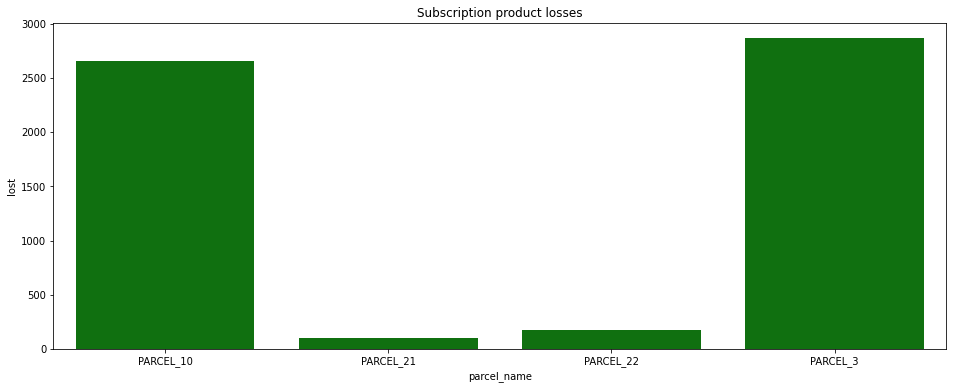

In [ ]:
data_to_vis = revenue_less_than_zero.groupby('parcel_name').sum().abs()['revenue'].reset_index()
data_to_vis.columns = ['parcel_name', 'lost']

plt.figure(figsize=(16, 6))
sns.barplot(data=data_to_vis, x='parcel_name', y='lost', color='green')
plt.title('Subscription product losses')

data_rev = data_to_vis['lost']
print(f'Total subscription cancellations in cash is -{np.round(data_rev.sum(), 2)}')

Чітко видно, що прибуток з реклами PARCEL_0 домінує, проте наступні чотири позиції усі inapp, що каже про гарну прибутковість з середини гри


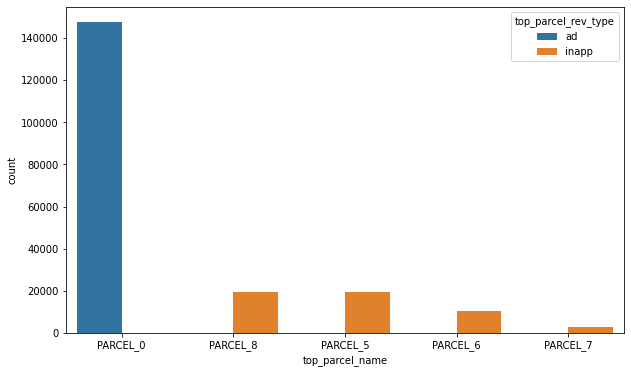

In [ ]:
# тепер досліджуємо найкращі позиції та їх типи

revenue_copy = revenue.copy()

def replace_feature(X):
    return X.lower().replace('parcel_', '')

def _change_parcel_rev_type(rv):
    return rv.split('_')[0]

def find_top_parcel_per_user(data):
    # data['parcel_name'] = data['parcel_name'].apply(replace_feature)     

    rev_data_parcel_sum = data.sort_values(by=['user_id', 'revenue_type']).groupby(by=['user_id', 'parcel_name', 'revenue_type']).sum()

    
    idx_tuple = list(rev_data_parcel_sum.unstack(0).fillna(0)['revenue'].idxmax().values)

    idx_tuple_df = pd.DataFrame(idx_tuple, columns=['top_parcel_name', 'top_parcel_rev_type'])

    idx_tuple_df['top_parcel_rev_type'] = idx_tuple_df['top_parcel_rev_type'].apply(_change_parcel_rev_type) 

    idx_df_grouped = idx_tuple_df.groupby('top_parcel_name').count().reset_index()
    idx_df_grouped.columns = ['top_parcel_name', 'count']

    idx_df_grouped = idx_df_grouped.merge(idx_tuple_df.drop_duplicates(), on='top_parcel_name')
    # idx_tuple_df.columns = ['top_parcel_name', 'top_parcel_rev_type', 'count']
    return idx_df_grouped.sort_values(by='count').nlargest(5, 'count')


df = find_top_parcel_per_user(revenue_copy)   

plt.figure(figsize=(10, 6))
sns.barplot(x=df['top_parcel_name'], y=df['count'], hue=df['top_parcel_rev_type'])

df

print('Чітко видно, що прибуток з реклами PARCEL_0 домінує, проте наступні чотири позиції усі inapp, що каже про гарну прибутковість з середини гри')

In [ ]:
user_rev_attr = revenue.groupby('user_id').sum().reset_index().merge(attribution, on='user_id').sort_values('revenue', ascending=False)
user_rev_attr

,user_id,revenue,transaction_count,install_dt,country,platform,source,device_brand,device_model
148779,UID_780637,2.082266e+03,155.0,2022-01-16 02:19:21.113000+00:00,COUNTRY_230,ios,SOURCE_69,BRAND_0,MODEL_4
55253,UID_142338,2.055297e+03,157.0,2022-01-11 01:37:48.874000+00:00,COUNTRY_230,ios,SOURCE_31,BRAND_0,MODEL_48
135630,UID_693506,1.993312e+03,61.0,2022-02-08 01:38:53.047000+00:00,COUNTRY_230,ios,SOURCE_31,UNK_BRAND,UNK_MODEL
1157,UID_1003140,1.960646e+03,109.0,2022-01-05 06:54:34.334000+00:00,COUNTRY_36,ios,SOURCE_69,BRAND_0,MODEL_22
26363,UID_1100123,1.928748e+03,139.0,2022-02-15 14:31:04.613000+00:00,COUNTRY_74,ios,SOURCE_31,UNK_BRAND,UNK_MODEL
...,...,...,...,...,...,...,...,...,...
56295,UID_146791,0.000000e+00,2.0,2022-01-25 11:27:10.522000+00:00,COUNTRY_74,ios,SOURCE_69,BRAND_0,MODEL_47
64607,UID_178595,0.000000e+00,2.0,2022-01-27 01:36:25.395000+00:00,COUNTRY_74,ios,SOURCE_31,BRAND_0,MODEL_0
7514,UID_1029703,-1.776357e-15,4.0,2022-02-27 10:32:48.918000+00:00,COUNTRY_74,ios,SOURCE_31,UNK_BRAND,UNK_MODEL
68387,UID_193132,-3.105750e+01,2.0,2022-01-28 08:35:27.011000+00:00,COUNTRY_72,ios,SOURCE_69,BRAND_0,MODEL_32



В цілому компанія з початку року до початку весни знижували витрати на рекламу, прибуток також знижувався
Бачимо, що тільки в початку року був різкий підйом, певно завдяки хайпу навколо гри та високих інвестицій в промоутінг гри.
Після цього бачимо посутповий спад та видно, що прибутки прямують до 0.
Навіть спроба повернути інтерес до гри в 20 числах Лютого і далі - не вдалася.



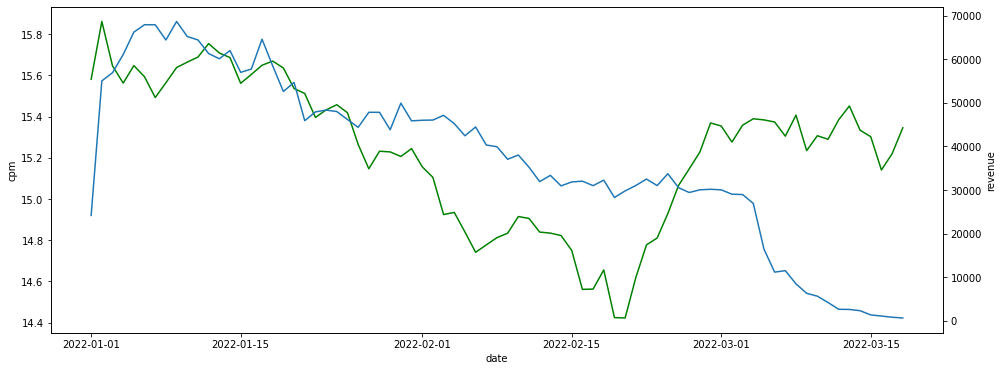

In [ ]:
# тепер поєднаємо характеристики користувача з відомим прибутком з користувача
# також пов'яжемо це з маркетинговою частину, а саме файл network_metrics.csv

netMetric_gb = netMetrics.groupby('source').sum()

revenue_gb_attribution = revenue.merge(attribution[['user_id', 'source']], how='left', on='user_id')\
                                .merge(netMetric_gb, how='left', on='source')

revenue_gb_attribution.set_index(pd.to_datetime(revenue_gb_attribution['date']), inplace=True)
revenue_gb_attribution.drop('date', axis=1, inplace=True)                                

revenue_gb_attribution_date = revenue_gb_attribution.groupby(level=0).sum()

# будуємо нові фічі, які є основними метриками в маркетингу та оцінки єфективності рекламних кампаній
revenue_gb_attribution_date['cpm'] = revenue_gb_attribution_date['cost'] * 1000 / revenue_gb_attribution_date['impressions']
revenue_gb_attribution_date['cpc'] = revenue_gb_attribution_date['cost']  / revenue_gb_attribution_date['clicks']
revenue_gb_attribution_date['cpi'] = revenue_gb_attribution_date['cost'] / revenue_gb_attribution_date['installs']

revenue_gb_attribution_date.dropna(inplace=True)

revenue_gb_attribution_date = revenue_gb_attribution_date.reset_index()

plt.figure(figsize=(16, 6))
sns.lineplot(data=revenue_gb_attribution_date, x='date', y='cpm', color='g')
ax2 = plt.twinx()
sns.lineplot(data=revenue_gb_attribution_date, x='date', y='revenue', ax=ax2)

print('''
В цілому компанія з початку року до початку весни знижували витрати на рекламу, прибуток також знижувався
Бачимо, що тільки в початку року був різкий підйом, певно завдяки хайпу навколо гри та високих інвестицій в промоутінг гри.
Після цього бачимо посутповий спад та видно, що прибутки прямують до 0.
Навіть спроба повернути інтерес до гри в 20 числах Лютого і далі - не вдалася.
''')


Разом зі зниженням прибутку та спробами повернути інтерес до гри, усі показники поступово знижувались.
Тим не менш в деяких періодах часу активність була вищою.
Ці висновки корисні якщо наприклад проаналізувати дату, що відбувалось в ті дні чи неділі, можливо оновлення, 
можливо вдала компанія і таке інше.



,date,revenue,transaction_count,impressions,clicks,installs,cost,cpm,cpc,cpi
0,2022-01-01,24154.670568,8907.0,5.890174e+10,1.903248e+10,4.903525e+08,9.177506e+08,15.581046,0.048220,1.871614
1,2022-01-02,55051.332969,21864.0,1.340645e+11,4.412200e+10,1.128532e+09,2.126500e+09,15.861773,0.048196,1.884306
2,2022-01-03,56934.053435,24971.0,1.651039e+11,5.385969e+10,1.383459e+09,2.583278e+09,15.646383,0.047963,1.867261
3,2022-01-04,61115.376591,24601.0,1.866860e+11,6.123728e+10,1.568626e+09,2.905297e+09,15.562478,0.047443,1.852129
4,2022-01-05,66255.959544,26167.0,2.192423e+11,7.277922e+10,1.854398e+09,3.430613e+09,15.647590,0.047137,1.849988
...,...,...,...,...,...,...,...,...,...,...
72,2022-03-14,2269.626529,1386.0,1.305438e+10,4.266146e+09,1.095309e+08,2.001761e+08,15.334016,0.046922,1.827576
73,2022-03-15,1303.463007,1012.0,9.065358e+09,2.932101e+09,7.580041e+07,1.387204e+08,15.302250,0.047311,1.830074
74,2022-03-16,1040.465708,786.0,6.599729e+09,2.096959e+09,5.460116e+07,9.992649e+07,15.140999,0.047653,1.830117
75,2022-03-17,770.455003,490.0,4.156955e+09,1.332253e+09,3.456245e+07,6.326831e+07,15.219868,0.047490,1.830551


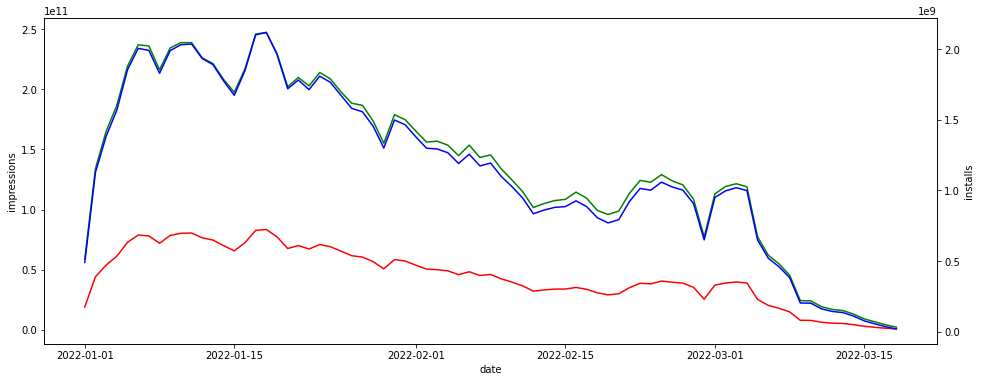

In [ ]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=revenue_gb_attribution_date, x='date', y='impressions', color='g')
sns.lineplot(data=revenue_gb_attribution_date, x='date', y='clicks', color='r')
ax2 = plt.twinx()
sns.lineplot(data=revenue_gb_attribution_date, x='date', y='installs', color='b', ax=ax2)

print(f'''
Разом зі зниженням прибутку та спробами повернути інтерес до гри, усі показники поступово знижувались.
Тим не менш в деяких періодах часу активність була вищою.
Ці висновки корисні якщо наприклад проаналізувати дату, що відбувалось в ті дні чи неділі, можливо оновлення, 
можливо вдала компанія і таке інше.
''')

revenue_gb_attribution_date

### Feature Engineering

In [13]:
# Об'єднуємо датасети з різних файлів. Задля кращого аналізу використовуючі часові фічі 
# cтворимо\перетворимо існуючі на різні часові проміжки. 

def merge_datasets(engagement):
    # engagement & revenue
    engagement = engagement.merge(attribution[['user_id','install_dt']], left_on='user_id', right_on='user_id', how='outer')
    revenue_copy = revenue.merge(attribution[['user_id', 'install_dt']], left_on='user_id', right_on='user_id', how='outer').sort_values('user_id').copy().fillna(0)

    engagement['date'] = pd.to_datetime(engagement['date'])
    engagement['install_dt'] = pd.to_datetime(engagement['install_dt']).dt.date

    grouped_engagement = engagement.groupby('user_id').sum()
    grouped_engagement.columns = [column_name.replace("_today", "_day" + str(14)) for column_name in engagement.drop(["date", "user_id", "install_dt"], axis=1).columns]

    revenue_copy['install_dt'] = pd.to_datetime(revenue_copy['install_dt']).dt.date
    revenue_copy['date'] = pd.to_datetime(revenue_copy['date']).dt.date


    for i in [1, 2, 3, 7]:
        temp_grouped = engagement.where(engagement['date']<engagement['install_dt']+timedelta(days=i)).dropna().drop(['date', 'install_dt'],axis=1).groupby('user_id').sum()
        temp_grouped.columns = [column_name.replace("_today", "_day" + str(i)) for column_name in engagement.drop(["date", "user_id", "install_dt"], axis=1).columns]
        grouped_engagement = pd.concat([grouped_engagement, temp_grouped], axis = 1).fillna(0)
        for revenue_type in ("ad_revenue", "inapp_revenue", "subscription_revenue"):
            temp_rev = (revenue_copy.where(np.logical_and(revenue_copy['date'] < revenue_copy['install_dt'] + timedelta(days=i), revenue_copy["revenue_type"] == revenue_type)).dropna().drop(['date', 'install_dt'], axis=1).groupby('user_id').sum())
            temp_rev.columns = [revenue_type + '_day_' + str(i), revenue_type + '_transaction_count_day_' + str(i)]
            grouped_engagement = pd.concat([grouped_engagement, temp_rev], axis =1).fillna(0)


    return grouped_engagement.join(attribution.set_index('user_id').drop(['install_dt'], axis = 1))

df = merge_datasets(engagement)

print('''
Отримуємо поточний датасет з отриманими метриками, які МОЖУТЬ бути корисними для моделі машинного навчанная.
Тим не менш, обирали самі фічі ми через побудову окремих XGBoost моделей використовуючи gain values.

Також робили те саме за допомогою лінійної регресії.
''')

df


Отримуємо поточний датасет з отриманими метриками, які МОЖУТЬ бути корисними для моделі машинного навчанная.
Тим не менш, обирали самі фічі ми через побудову окремих XGBoost моделей використовуючи gain values.

Також робили те саме за допомогою лінійної регресії.



,vippass_offer_seen_times_day14,total_offer_seen_times_day14,tickets_spent_day14,spinner_seen_times_day14,shop_seen_times_day14,sessions_time_day14,sessions_amount_day14,rewarded_ads_shown_day14,premium_clothes_day14,premium_choices_day14,...,ad_revenue_transaction_count_day_7,inapp_revenue_day_7,inapp_revenue_transaction_count_day_7,subscription_revenue_day_7,subscription_revenue_transaction_count_day_7,country,platform,source,device_brand,device_model
user_id,,,,,,,,,,,,,,,,,,,,,
UID_0,2.0,11.0,7.0,0.0,1.0,1.822808e+10,9.0,0.0,0.0,7.0,...,0.0,28.238067,4.0,12.104322,1.0,COUNTRY_97,ios,SOURCE_69,BRAND_0,MODEL_0
UID_1,0.0,0.0,0.0,0.0,0.0,7.448912e+08,2.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,COUNTRY_56,ios,SOURCE_69,BRAND_0,MODEL_0
UID_10,0.0,18.0,5.0,0.0,0.0,2.554173e+10,3.0,0.0,1.0,13.0,...,0.0,23.692822,2.0,0.000000,0.0,COUNTRY_230,ios,SOURCE_69,BRAND_0,MODEL_7
UID_100,0.0,1.0,1.0,0.0,0.0,1.680099e+09,2.0,0.0,0.0,1.0,...,0.0,0.000000,0.0,0.000000,0.0,COUNTRY_230,ios,SOURCE_69,BRAND_0,MODEL_12
UID_1000,0.0,0.0,0.0,0.0,0.0,3.761900e+08,1.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,COUNTRY_230,android,SOURCE_68,BRAND_2,MODEL_352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UID_999995,0.0,2.0,0.0,0.0,0.0,3.183710e+08,2.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,COUNTRY_36,ios,SOURCE_69,BRAND_0,MODEL_12
UID_999996,0.0,1.0,0.0,0.0,0.0,8.319610e+08,1.0,0.0,1.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,COUNTRY_36,ios,SOURCE_58,BRAND_0,MODEL_22
UID_999997,0.0,0.0,0.0,0.0,0.0,1.294711e+08,2.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,COUNTRY_151,ios,SOURCE_69,BRAND_0,MODEL_0


In [14]:
# закінчуємо етап feature enginnering вибіркою найпопулярніших значень нижче наведних фіч, 
# задля оптимізації роботи з моделлю

def transform(data):
    data = data.copy()

    data['not_common_source'] = True
    data['not_common_country'] = True
    data['not_common_device_brand'] = True
    data['not_common_device_model'] = True

    for source in ("SOURCE_31", "SOURCE_69", "SOURCE_58", "SOURCE_12", "SOURCE_61"): ## Отбор популярных источников
        data[source] = (data['source'] == source).astype(int)
        data['not_common_source'] = np.logical_and((data['source'] != source), data['not_common_source']).astype(int)

    for country in ("COUNTRY_230", "COUNTRY_74", "COUNTRY_151", "COUNTRY_12", "COUNTRY_36"):## Отбор популярных стран скачивания
        data[country] = (data['country'] == country).astype(int)
        data['not_common_country'] = np.logical_and((data['country'] != country), data['not_common_country']).astype(int)

    for dev_brand in ("BRAND_0", "BRAND_2"):## Отбор популярных стран скачивания
        data[dev_brand] = (data['device_brand'] == dev_brand).astype(int)
        data['not_common_device_brand'] = np.logical_and((data['device_brand'] != dev_brand), data['not_common_device_brand']).astype(int)

    for dev_model in ("MODEL_0", "MODEL_12", "MODEL_22", "MODEL_13"):## Отбор популярных стран скачивания
        data[dev_model] = (data['device_model'] == dev_model).astype(int)
        data['not_common_device_model'] = np.logical_and((data['device_model'] != dev_model), data['not_common_device_model']).astype(int)

    data = pd.get_dummies(data, columns=['platform'], prefix = 'is', drop_first = True)

    return data.drop(["country", "source", "device_brand", "device_model"], axis=1)


data_transformed = transform(df)

In [22]:
targets = ['inapp_revenue', 'ad_revenue', 'subscription_revenue']
data_processed = data_transformed.join(target.set_index('user_id'))

data_processed

,vippass_offer_seen_times_day14,total_offer_seen_times_day14,tickets_spent_day14,spinner_seen_times_day14,shop_seen_times_day14,sessions_time_day14,sessions_amount_day14,rewarded_ads_shown_day14,premium_clothes_day14,premium_choices_day14,...,BRAND_2,MODEL_0,MODEL_12,MODEL_22,MODEL_13,is_ios,ad_revenue,subscription_revenue,inapp_revenue,revenue
user_id,,,,,,,,,,,,,,,,,,,,,
UID_0,2.0,11.0,7.0,0.0,1.0,1.822808e+10,9.0,0.0,0.0,7.0,...,0,1,0,0,0,1,0.000000,36.234482,28.238067,64.472549
UID_1,0.0,0.0,0.0,0.0,0.0,7.448912e+08,2.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0.000000,0.000000,0.000000,0.000000
UID_10,0.0,18.0,5.0,0.0,0.0,2.554173e+10,3.0,0.0,1.0,13.0,...,0,0,0,0,0,1,0.000000,0.000000,53.318739,53.318739
UID_100,0.0,1.0,1.0,0.0,0.0,1.680099e+09,2.0,0.0,0.0,1.0,...,0,0,1,0,0,1,0.000000,0.000000,0.000000,0.000000
UID_1000,0.0,0.0,0.0,0.0,0.0,3.761900e+08,1.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UID_999995,0.0,2.0,0.0,0.0,0.0,3.183710e+08,2.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0.000000,0.000000,0.000000,0.000000
UID_999996,0.0,1.0,0.0,0.0,0.0,8.319610e+08,1.0,0.0,1.0,0.0,...,0,0,0,1,0,1,0.000000,0.000000,0.000000,0.000000
UID_999997,0.0,0.0,0.0,0.0,0.0,1.294711e+08,2.0,0.0,0.0,0.0,...,0,1,0,0,0,1,0.000000,0.000000,0.000000,0.000000


#### Modeling

In [28]:
# Фічі нижче були обрані шляхом побудування окремих xgboost models.
# # Також були використані shap_values та лінійна регресія, однак кращого результату вони не показали 

top_important_features = ['diamonds_spent_day14',
 'inapp_revenue_day_7',
 'inapp_revenue_day_3',
 'premium_choices_day14',
 'sessions_time_day7',
 'sessions_time_day1',
 'diamonds_spent_day7',
 'sessions_time_day14',
 'subscription_revenue_day_7',
 'total_offer_seen_times_day7',
 'sessions_amount_day14',
 'total_offer_seen_times_day14',
 'ad_revenue_day_7',
 'dialogues_shown_day14',
 'in_app_seen_times_day7',
 'spinner_seen_times_day14']

model_one = MultiOutputRegressor(xgb.XGBRegressor())

X_train, X_test, y_train, y_test = train_test_split(data_processed[top_important_features], data_processed[targets])

model_one.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
     

In [87]:
predictions = model_one.predict(X_test)
df_2 = X_test.reset_index()
df_2['predictions'] = predictions.sum(axis=1)

obs_data = df_2[['user_id', 'predictions']]

obs_data_copy = copy.deepcopy(obs_data)

obs_data_copy_merged = obs_data_copy.merge(attribution[['user_id', 'install_dt', 'country', 'platform', 'source']], on='user_id')
obs_data_copy_merged.set_index([pd.DatetimeIndex(obs_data_copy_merged['install_dt']), 'source'], inplace=True)

obs_data_copy_merged.groupby(level=[0, 1]).sum().swaplevel()

predictions
source    install_dt                                   
SOURCE_58 2022-01-01 00:00:09.196000+00:00     0.068281
SOURCE_69 2022-01-01 00:00:20.739000+00:00     0.068281
          2022-01-01 00:00:44.970000+00:00     0.068281
          2022-01-01 00:00:50.895000+00:00     0.091109
          2022-01-01 00:00:53.160000+00:00     0.350252
...                                                 ...
SOURCE_61 2022-03-04 23:57:26.192000+00:00     0.213695
SOURCE_31 2022-03-04 23:57:33.800000+00:00    25.145433
SOURCE_21 2022-03-04 23:58:47.560000+00:00     0.068281
SOURCE_64 2022-03-04 23:58:51.746000+00:00     0.132602
SOURCE_21 2022-03-04 23:58:57.725000+00:00     0.068281

[207751 rows x 1 columns]

In [30]:
def get_metrics(model, X, y, one_target=True, model_name=None, RMSE=True, MAE=True, MAPE=True, R2=False, MSE=False):
    """
    :param model: ML model, which will predict on X
    :param X: data frame, features
    :param y: data frame, target values
    :param one_target: bool, print metrics for 1 target or for 3
    :param model_name: string, name of the model, if not None name will be printed
    :param RMSE: bool, Root mean square error
    :param MAE: bool, Mean absolute error
    :param MAPE: bool,Mean absolute percentage error
    :param R2: bool, Root 2 error
    :param MSE: bool, Mean square error
    :return: None, prints errors on specified metrics
    """
    metrics = (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error)
    metric_flags = {"RMSE": RMSE, "MAE": MAE, "MAPE": MAPE, "R2": R2, "MSE": MSE}

    print('-'*20)
    if model_name:
        print(f"Model = {model_name}")
    for metric, m_flag in zip(metrics, metric_flags):
        if metric_flags[m_flag]:
            if m_flag=='RMSE':
                print(f"{m_flag} on 3 target = {metric(y, model.predict(X), squared=False)}" if one_target==False
                      else f"{m_flag} on 1 target = {metric(y.sum(axis=1), model.predict(X).sum(axis=1), squared=False)}")
            else:
                print(f"{m_flag} on 3 target = {metric(y, model.predict(X))}" if one_target==False
                      else f"{m_flag} on 1 target = {metric(y.sum(axis=1), model.predict(X).sum(axis=1))}")
    print('-'*20)

get_metrics(model_one, X_test, y_test, one_target=False)

--------------------
RMSE on 3 target = 7.572254667085201
MAE on 3 target = 0.5758050040289913
MAPE on 3 target = 475750749411654.5
--------------------


In [36]:
from typing import Tuple

barplot_titles = {
    'ad_revenue': {
        'gain': 'GAIN | Сер. вплив на $ з реклами',
        'shap': 'SHAP | Сер. вплив на $ з реклами'
    },
    'subscription_revenue': {
        'gain': 'GAIN | Сер. вплив на $ з підписок',
        'shap': 'SHAP | Сер. Вплив на $ з підписок'
    },
    'inapp_revenue': {
        'gain': 'GAIN | Сер. вплив на $ з середини гри',
        'shap': 'SHAP | Сер. вплив на $ з середини гри'
    }
}

dependenciesplot_titles = {
    'subscription_revenue': 'Вплив окремих значень на $ з підписок',
    'inapp_revenue': 'Вплив окремих значень на $ з середини гри',
    'ad_revenue': 'Вплив окремих значень на $ з реклами'
}

titles_fontdict = {'fontsize': 13, 'fontweight': 'bold'}

TARGET = ["ad_revenue", "subscription_revenue", "inapp_revenue"]


def _get_feat_imp_parameter(estimator, param='gain'):
    feature_important = estimator.get_booster().get_score(importance_type=param)
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    return pd.DataFrame(data=values, index=keys, columns=['score'])\
        .nlargest(100, columns=['score'])\
        .sort_values(by='score', ascending=False)


def _get_shap_values(X, estimator):
    return shap.TreeExplainer(estimator).shap_values(X)


def plot_score_barplot(df, index):
    palette = sns.color_palette('Blues', n_colors=1)
    sns.barplot(x=df.iloc[:, 0], y=df.index, data=df, palette=palette)
    plt.tick_params('both', labelsize=11.0)
    plt.xlabel('avg. gain values', fontdict={'fontsize': 11})
    plt.title(barplot_titles[TARGET[int(index/2)]]['gain'], fontdict={'fontsize': 13, 'fontweight': 'bold'})
    return


def plot_shap_barplot(shap_values, X, index):
    shap.summary_plot(shap_values, X, max_display=10,
                      color="#6aaed6", plot_type="bar", plot_size=(20, 8), show=False)
    plt.tick_params('both', labelsize=11.0)
    plt.xlabel('shap values', fontdict={'fontsize': 11})
    plt.title(barplot_titles[TARGET[int(index/2)]]['shap'], fontdict={'fontsize': 13, 'fontweight': 'bold', 'verticalalignment': 'top'})

    plt.tight_layout(pad=0.4, h_pad=0.8)
    return


def plot_shap_summaryplot(shap_values, X, index, summary_plot_type, x_lims):
    target_key = TARGET[index-1]

    shap.summary_plot(shap_values, X, max_display=10, plot_type=summary_plot_type, plot_size=(25, 20), show=False)
    plt.tick_params('both', labelsize=13.0)
    plt.xlabel('shap values', fontdict={'fontsize': 13})
    plt.title(dependenciesplot_titles[target_key], fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'top'})

    if target_key in x_lims.keys():
        x_lims_value = x_lims[target_key]
        if isinstance(x_lims_value, Tuple)\
                and len(x_lims_value) == 2:\
            plt.xlim(x_lims_value)

    plt.tight_layout(pad=0.4, h_pad=0.9)
    return


def plot_feature_importance(X, estimators_, is_global=True, summary_plot_type='dot', x_lims={}, to_save=False, file_name=None):
    index = 1
    for estimator in estimators_:
        # SHAP Values
        shap_values = _get_shap_values(X, estimator)
        # GAIN values
        gain_df = _get_feat_imp_parameter(estimator, 'total_gain')
        # ==========================
        if not is_global:
            plt.subplot(3, 1, index)
            plot_shap_summaryplot(shap_values, X, index, summary_plot_type=summary_plot_type, x_lims=x_lims)
            index += 1
            continue
        plt.subplot(3, 2, index)
        plot_score_barplot(gain_df, index)
        # ==========================
        plt.subplot(3, 2, index+1)
        plot_shap_barplot(shap_values, X, index)
        index += 2

    if to_save\
            and file_name:
        plt.savefig(file_name)
    return

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


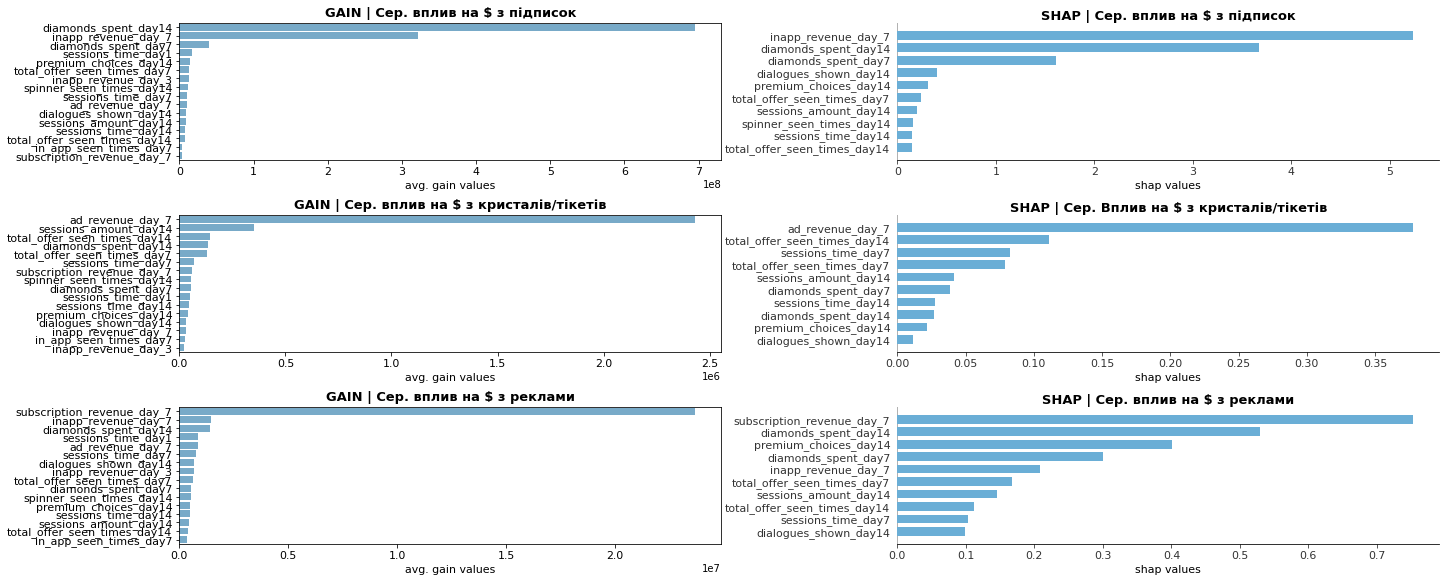

In [32]:
plot_feature_importance(X_test, model_one.estimators_)

print('''
Основне: shap values дає повну перевагу фічам за 7, 14 днів. 
З чого робимо висновок, що задля точного та максимального результату наших предикшинів, наша модель потребує
7 днів. Ці гіпотези мають сенс, адже ми зацікавлені в тому, щоб юзер продовжував грати та приносити дохід.

Щодо фіч, бачимо як для прибутки з реклами є край важливим прибутком з середини гри, певно таким чином ми впевнені, що
юзер платіжно-спроможний, також знов ігрова активність, а саме в траті кристалів за 7 та 14 днів.

Аналогічно можна дослідити інши графіки.
''')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


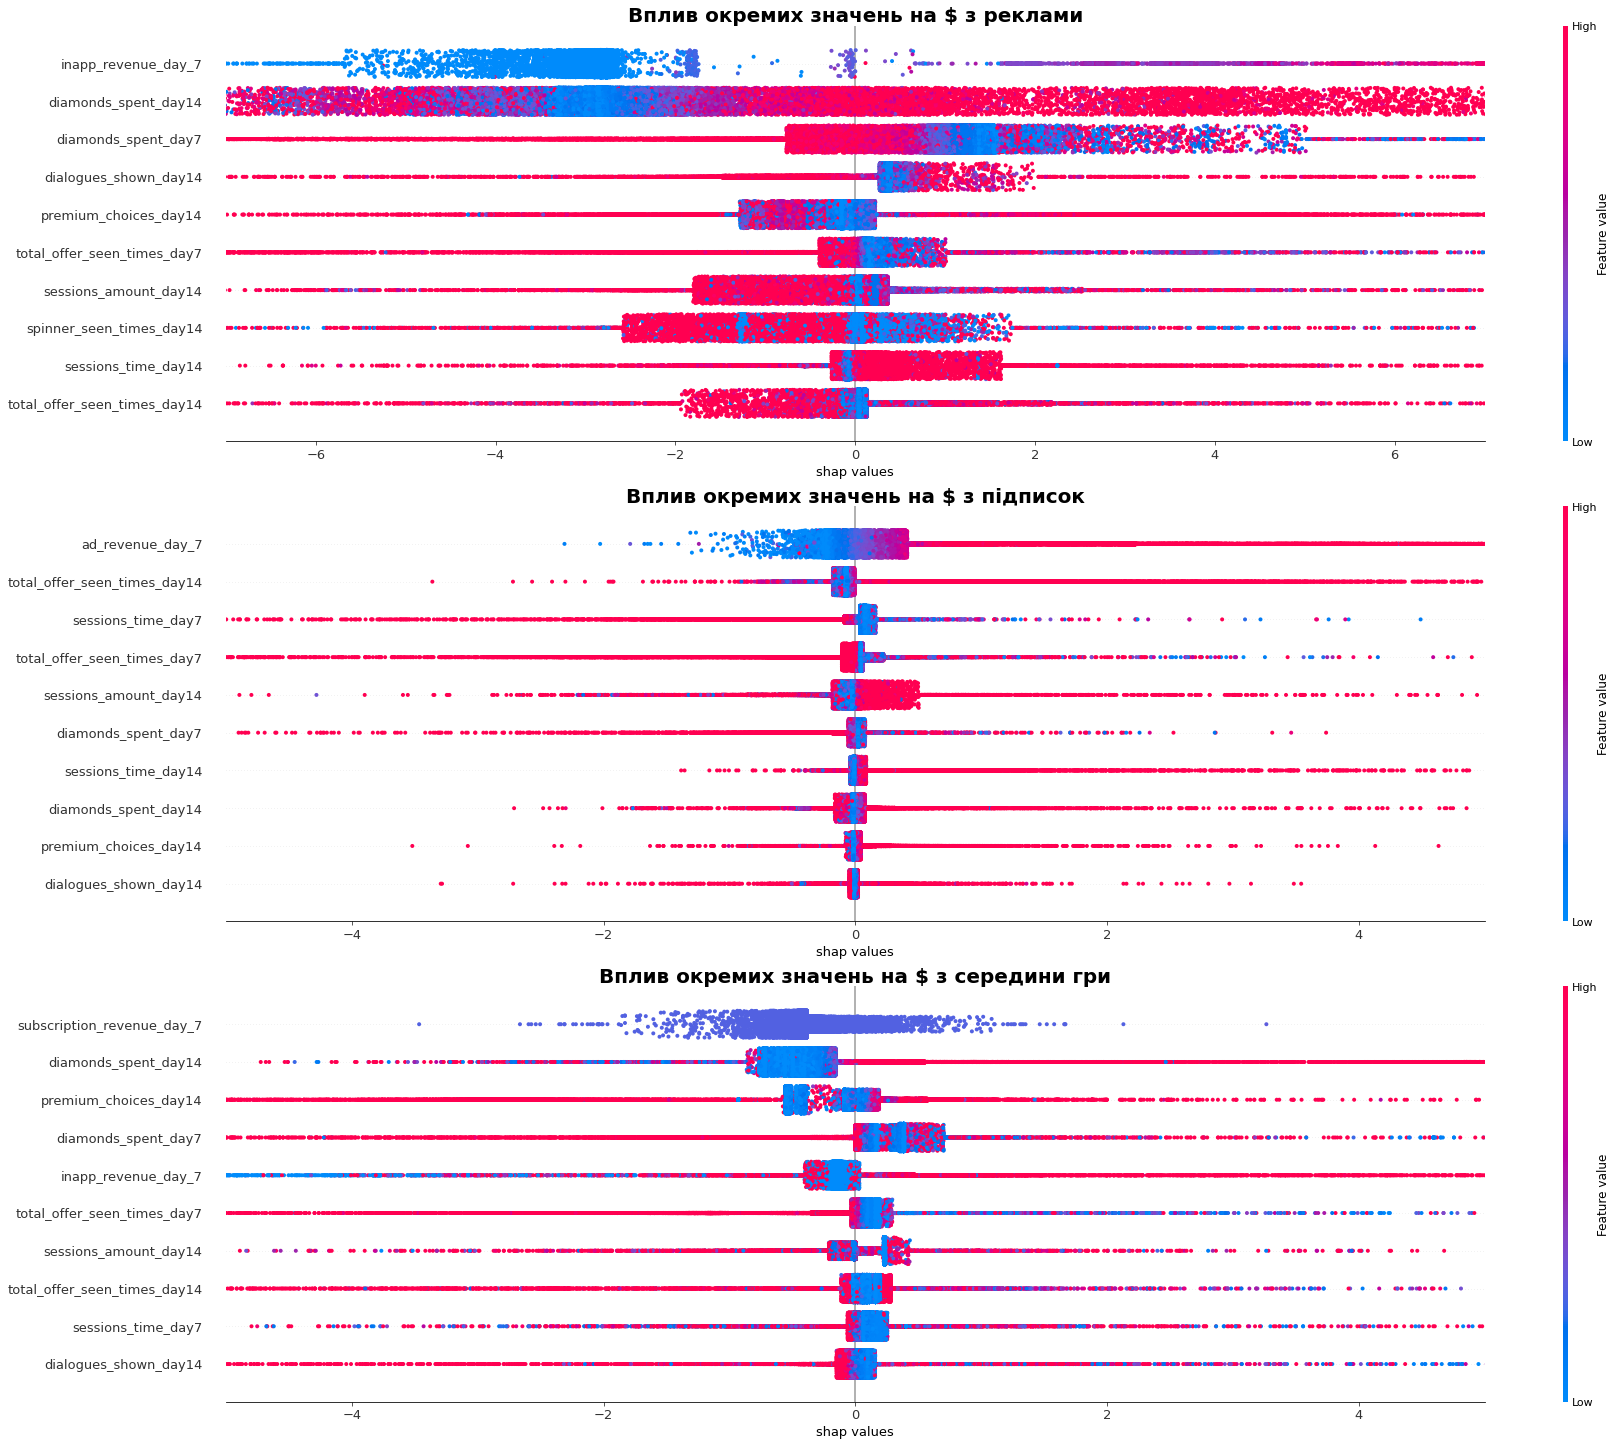

In [39]:
plot_feature_importance(X_test, model_one.estimators_, is_global=False, x_lims={'ad_revenue': (-7, 7),
                                                                                'inapp_revenue': (-5, 5),
                                                                                'subscription_revenue': (-5, 5)
                                                                                })

In [41]:
titles = {
    'subscription_revenue': '$ з підписок',
    'inapp_revenue': '$ з середини гри',
    'ad_revenue': '$ з реклами'
}

def plot_dependencies(X, estimators_, features_dict={}):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

    for index, target_key in enumerate(features_dict.keys()):
        index_of_target = TARGET.index(target_key)
        explainer = shap.TreeExplainer(estimators_[index_of_target])

        shap_values = explainer.shap_values(X)
        shap_features_list = features_dict[TARGET[index]]
        for feature_index, feature in enumerate(shap_features_list):
            shap.dependence_plot(feature, shap_values, X,
                                 ax=axes[index, feature_index], x_jitter=0.5, alpha=0.7, show=False)
            plt.tick_params('both', labelsize=13.0)

    plt.tight_layout(pad=0.5)